Dataset Shape: (200020, 17)
Introduced 12.0% label noise.

Model Accuracy: 0.8801994800519948

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     41647
           1       0.88      0.87      0.87     38361

    accuracy                           0.88     80008
   macro avg       0.88      0.88      0.88     80008
weighted avg       0.88      0.88      0.88     80008


Cross Validation Accuracy: 0.7987801219878012


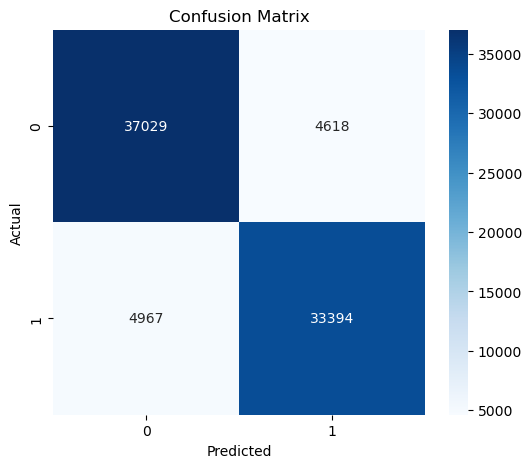

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv("patient_data.csv")
data.columns = data.columns.str.strip()

print("Dataset Shape:", data.shape)
for column in data.select_dtypes(include=['object']).columns:
    if column != "Risk Level":
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
target_encoder = LabelEncoder()
data["Risk Level"] = target_encoder.fit_transform(data["Risk Level"])
X = data.drop("Risk Level", axis=1)
y = data["Risk Level"].copy()
np.random.seed(42)
noise_fraction = 0.12
n_samples = len(y)
n_noisy = int(noise_fraction * n_samples)
noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
y.iloc[noisy_indices] = 1 - y.iloc[noisy_indices]
print(f"Introduced {noise_fraction*100}% label noise.")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy:", accuracy)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
cv_scores = cross_val_score(model, X, y, cv=5)
print("\nCross Validation Accuracy:", cv_scores.mean())
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [2]:
import joblib
joblib.dump(model, "patient_risk_model.pkl")
print("Model saved successfully as patient_risk_model.pkl")

Model saved successfully as patient_risk_model.pkl


In [4]:
!pip install fastapi uvicorn joblib pandas numpy

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd
import numpy as np
model = joblib.load("patient_risk_model.pkl")
target_encoder = joblib.load("target_encoder.pkl")

try:
    feature_encoders = joblib.load("feature_encoders.pkl")
except:
    feature_encoders = None

app = FastAPI(title="Patient Risk Prediction API")

class PatientInput(BaseModel):
    Age: int
    Gender: str
    BloodPressure: int
    HeartRate: int
    Temperature: float

@app.post("/predict")
def predict(patient: PatientInput):

    # Convert input to DataFrame
    input_dict = patient.dict()
    input_df = pd.DataFrame([input_dict])

    # Encode categorical features if available
    if feature_encoders:
        for column, encoder in feature_encoders.items():
            if column in input_df.columns:
                input_df[column] = encoder.transform(input_df[column])

    # Model prediction
    prediction = model.predict(input_df)
    probabilities = model.predict_proba(input_df)

    result = target_encoder.inverse_transform(prediction)[0]
    confidence = float(np.max(probabilities))

    # Department Recommendation Logic
    if result == "High":
        department = "Emergency"
    elif patient.HeartRate > 120 or patient.BloodPressure > 160:
        department = "Cardiology"
    else:
        department = "General Medicine"

    return {
        "Predicted_Risk_Level": result,
        "Confidence": round(confidence, 3),
        "Recommended_Department": department
    }
